In [1]:
import os
import cv2
import random
import shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
train_dir = './new_dataset_9/Train'
validation_dir = './new_dataset_9/Validation'
test_dir='./new_dataset_9/Test'

In [3]:
def data_generators(TRAINING_DIR, VALIDATION_DIR,TESTING_DIR):

  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.3,
                                   horizontal_flip = True,
                                   vertical_flip = True)

  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

  validation_datagen = ImageDataGenerator( rescale = 1.0/255.)

  
  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

  testing_datagen = ImageDataGenerator( rescale = 1.0/255.)
    
  testing_generator = testing_datagen.flow_from_directory(TESTING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))

  return train_generator, validation_generator, testing_generator

In [4]:
train_generator, validation_generator,testing_generator = data_generators(train_dir, validation_dir,test_dir)

Found 566 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 74 images belonging to 5 classes.


In [5]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D

In [6]:
base_model=MobileNet(weights='imagenet',include_top=False,input_shape = (150,150, 3))
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
x=Dense(216,activation='relu')(x)
preds=Dense(5,activation='softmax')(x)

In [7]:
len(base_model.layers)

87

In [8]:
for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:86]:
    layer.trainable = True

In [9]:
model_mobilenet=Model(inputs=base_model.input,outputs=preds)

In [16]:
SGD=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)

In [17]:
model_mobilenet.compile(optimizer=SGD,loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.85:
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True

In [22]:
callbacks = myCallback()

In [23]:
history = model_mobilenet.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                             verbose=1,callbacks=[callbacks])

Epoch 1/50
9/9 [==============================] - 9s 987ms/step - loss: 0.0610 - accuracy: 0.9788 - val_loss: 1.1123 - val_accuracy: 0.7875
Epoch 2/50
9/9 [==============================] - 9s 966ms/step - loss: 0.1022 - accuracy: 0.9682 - val_loss: 1.2576 - val_accuracy: 0.7625
Epoch 3/50
9/9 [==============================] - 9s 972ms/step - loss: 0.0641 - accuracy: 0.9788 - val_loss: 1.1877 - val_accuracy: 0.8000
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 0.0529 - accuracy: 0.9823 - val_loss: 1.2375 - val_accuracy: 0.7750
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 0.0606 - accuracy: 0.9806 - val_loss: 1.3753 - val_accuracy: 0.7625
Epoch 6/50
9/9 [==============================] - 9s 1s/step - loss: 0.0947 - accuracy: 0.9735 - val_loss: 1.1486 - val_accuracy: 0.7750
Epoch 7/50
9/9 [==============================] - 10s 1s/step - loss: 0.0405 - accuracy: 0.9894 - val_loss: 1.0927 - val_accuracy: 0.8000
Epoch 8/50
9/9 [=============

In [24]:
results = model_mobilenet.evaluate(testing_generator, batch_size=128)

2/2 [==============================] - 0s 35ms/step - loss: 1.5469 - accuracy: 0.7568


In [43]:
model_mobilenet.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 151, 151, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)       

In [27]:
    model1_json = model_mobilenet.to_json()
    with open("model1_mobilenet.json", "w") as json_file:
        json_file.write(model1_json)
    # serialize weights to HDF5
    model_mobilenet.save("model1_mobilenet.h5")
    print("Saved model to disk")

Saved model to disk


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

def plot_acc_model(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    
def plot_loss_model(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

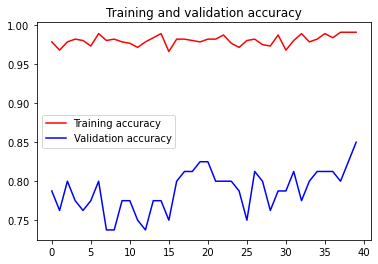

<Figure size 432x288 with 0 Axes>

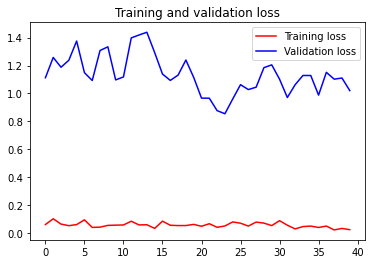

<Figure size 432x288 with 0 Axes>

In [30]:
plot_acc_model(acc, val_acc, epochs)
plot_loss_model(loss, val_loss, epochs)

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def confussion_matrix(test_true, test_pred, test_class):
    cm = confusion_matrix(test_true, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class)
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax,cmap=plt.cm.Blues)
    plt.show()

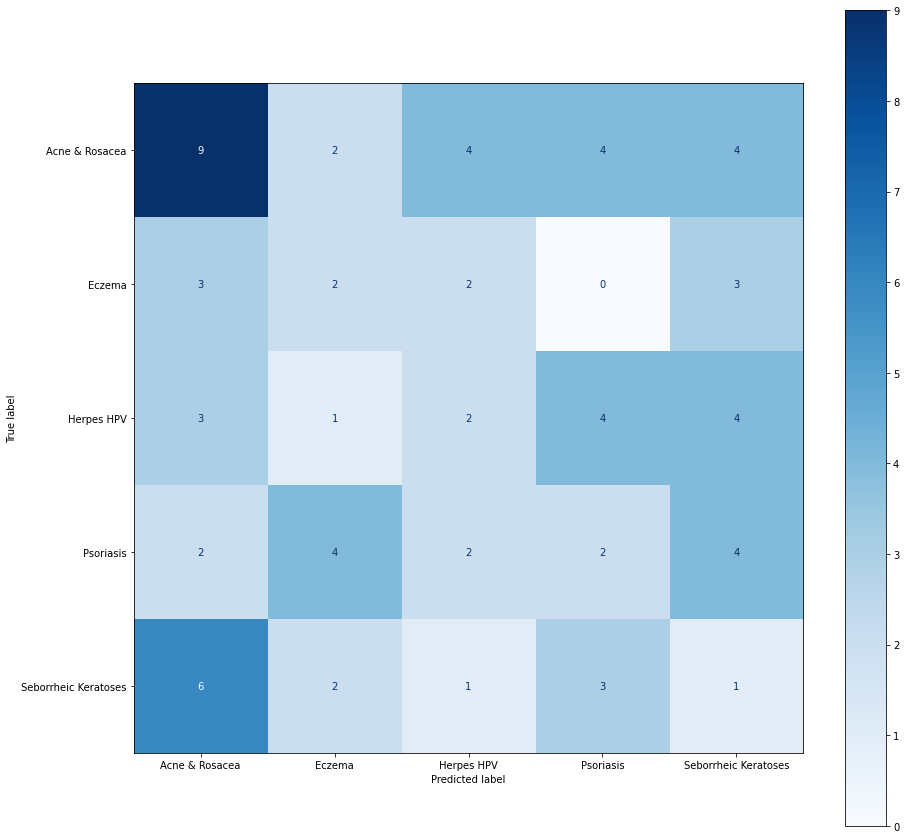

In [32]:
testing_pred_raw = model_mobilenet.predict(testing_generator)
testing_pred = np.argmax(testing_pred_raw, axis=1)
testing_true = testing_generator.classes
testing_class = ["Acne & Rosacea", "Eczema", "Herpes HPV", "Psoriasis", "Seborrheic Keratoses"]
confussion_matrix(testing_true, testing_pred, testing_class)

In [33]:
def cluster_segmentation(img, k=5):
  pixel_values = img.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

  _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  centers=np.uint8(centers)
  labels = labels.flatten()
  segmented_img = centers[labels.flatten()]
  segmented_img = segmented_img.reshape(img.shape)
  masked_img =  np.copy(img)
  masked_img = masked_img.reshape((-1, 3))
  cluster = 2
  masked_img[labels==cluster] = [0, 0, 0]
  masked_img = masked_img.reshape(img.shape)

  return masked_img

In [34]:
def segmentation_generators(TRAINING_DIR, VALIDATION_DIR,TESTING_DIR, PREPROCESSING_IMG):

  train_datagen = ImageDataGenerator(preprocessing_function=PREPROCESSING_IMG,
                                   rescale = 1./255.,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.3,
                                   horizontal_flip = True,
                                   vertical_flip = True)

  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

  validation_datagen = ImageDataGenerator(preprocessing_function=PREPROCESSING_IMG,
                                          rescale = 1.0/255.)

  
  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150, 150))

  testing_datagen = ImageDataGenerator(preprocessing_function=PREPROCESSING_IMG,
                                       rescale = 1.0/255.)
    
  testing_generator = testing_datagen.flow_from_directory(TESTING_DIR,
                                                    batch_size = 64,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))

  return train_generator, validation_generator, testing_generator

In [35]:
train_generator, validation_generator,testing_generator = segmentation_generators(train_dir, validation_dir,test_dir, cluster_segmentation)

Found 566 images belonging to 5 classes.
Found 80 images belonging to 5 classes.
Found 74 images belonging to 5 classes.


In [37]:
history = model_mobilenet.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator)

Epoch 1/30
9/9 [==============================] - 67s 7s/step - loss: 0.5556 - accuracy: 0.8198 - val_loss: 1.1315 - val_accuracy: 0.6375
Epoch 2/30
9/9 [==============================] - 68s 8s/step - loss: 0.4734 - accuracy: 0.8145 - val_loss: 1.0793 - val_accuracy: 0.6625
Epoch 3/30
9/9 [==============================] - 68s 8s/step - loss: 0.4795 - accuracy: 0.8304 - val_loss: 1.0955 - val_accuracy: 0.6625
Epoch 4/30
9/9 [==============================] - 67s 7s/step - loss: 0.4741 - accuracy: 0.8198 - val_loss: 1.0020 - val_accuracy: 0.6875
Epoch 5/30
9/9 [==============================] - 67s 7s/step - loss: 0.4450 - accuracy: 0.8498 - val_loss: 0.7299 - val_accuracy: 0.7000
Epoch 6/30
9/9 [==============================] - 69s 8s/step - loss: 0.3865 - accuracy: 0.8498 - val_loss: 0.8735 - val_accuracy: 0.7000
Epoch 7/30
9/9 [==============================] - 68s 8s/step - loss: 0.3835 - accuracy: 0.8534 - val_loss: 1.0677 - val_accuracy: 0.6875
Epoch 8/30
9/9 [==================

In [38]:
results = model_mobilenet.evaluate(testing_generator, batch_size=128)

2/2 [==============================] - 1s 590ms/step - loss: 4.2382 - accuracy: 0.4865


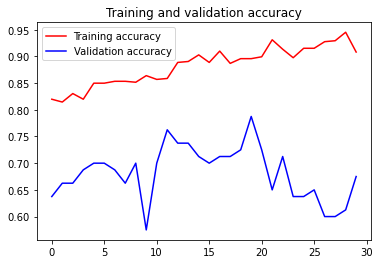

<Figure size 432x288 with 0 Axes>

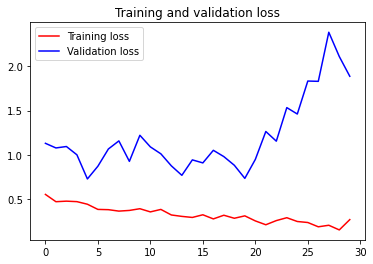

<Figure size 432x288 with 0 Axes>

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plot_acc_model(acc, val_acc, epochs)
plot_loss_model(loss, val_loss, epochs)

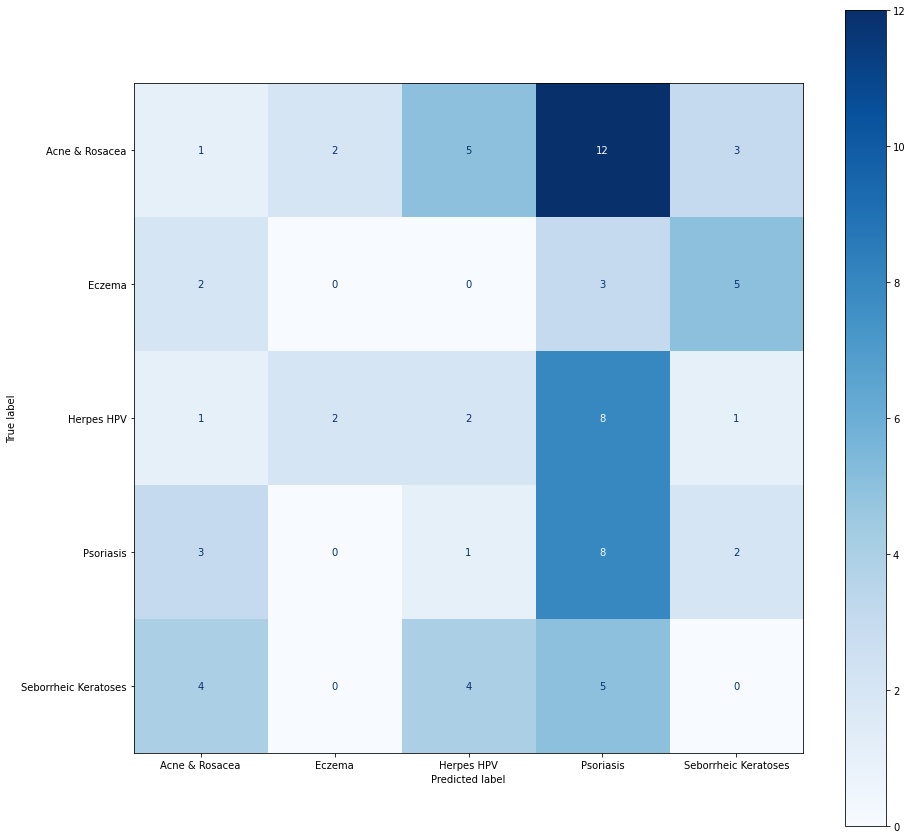

In [40]:
testing_pred_raw = model_mobilenet.predict(testing_generator)
testing_pred = np.argmax(testing_pred_raw, axis=1)
testing_true = testing_generator.classes
testing_class = ["Acne & Rosacea", "Eczema", "Herpes HPV", "Psoriasis", "Seborrheic Keratoses"]
confussion_matrix(testing_true, testing_pred, testing_class)

In [ ]:
model1_json = model_mobilenet.to_json()
with open("model1_mobilenet.json", "w") as json_file:
    json_file.write(model1_json)
# serialize weights to HDF5
model_mobilenet.save("model1_mobilenet.h5")
print("Saved model to disk")

In [42]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploads = files.upload()

n_files = len(uploads)
fig = plt.figure(figsize=(2, 2 * n_files))

for i, filename in enumerate(uploads):
  img = image.load_img(
      filename,
      target_size=(224, 224)
  )
  x = image.img_to_array(img)/255
  x = np.expand_dims(x, axis=0)

  predict = model.predict(x)
  class_prediction = np.argmax(predict)
  prediction = class_dict[class_prediction]
  
  
  ax = fig.add_subplot(n_files, 1, i+1)
  ax.imshow(img)
  ax.set_title(prediction)
  ax.axis(False)
  print('percentage:')
  print(predict)

NameError: name 'files' is not defined